# QClus Tutorial

In [1]:
import sys
sys.path.append('..')

import qclus as qc
from qclus.gene_lists import *
from qclus.utils import *
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
splicing_path = "fraction_unspliced_loom.csv"
counts_path = "../../samples/sample_lq.h5"

In [3]:
fraction_unspliced = pd.read_csv(splicing_path, index_col=0)

In [4]:
fraction_unspliced

,fraction_unspliced
AAACGAACATTCTCTA,0.523716
AAACGAAAGCCGCTTG,0.505452
AAACGCTCACGCTGTG,0.435658
AAACGAACAACTGCTA,0.385696
AAACGCTGTGGGTATG,0.624506
...,...
TTTGTTGGTCCTGGTG,0.595714
TTTGTTGTCCTAAACG,0.695590
TTTGTTGTCTACTGAG,0.496416
TTTGTTGTCGATTGGT,0.659710


In [5]:

adata = qc.run_qclus(counts_path, fraction_unspliced,
                        gene_set_dict=celltype_gene_set_dict,           # exact gene sets can be found in gene_lists.py
                        nucl_gene_set=nucl_genes_50,                    # exact gene set can be found in gene_lists.py
                        minimum_genes=500,                              # minimum number of detected genes allowed in droplet
                        maximum_genes=6000,                             # maximum number of detected genes allowed in droplet
                        max_mito_perc=40,                               # maximum percentage of mitochondrial content allowed in droplet
                        clustering_features=['pct_counts_nonCM',        # Clustering features as defined in publication
                                        'pct_counts_nucl_30',           
                                        'pct_counts_MT',            
                                        'pct_counts_CM_cyto', 
                                        'pct_counts_CM_nucl', 
                                        'fraction_unspliced'], 
                        clustering_k=4,                                 # number of clusters to generate
                        clusters_to_select=["0", "1"],                  # which clusters, in order of quality, to select
                        scrublet_filter=True,                           # whether or not to apply the Scrublet algorith,
                        scrublet_expected_rate=0.06,                    
                        scrublet_minimum_counts=2,                      
                        scrublet_minimum_cells=3,                       
                        scrublet_minimum_gene_variability_pctl=85,      
                        scrublet_n_pcs=30,                              
                        scrublet_thresh=0.1,                            
                        outlier_filter=True,                            # whether or not to apply outlier filter
                        outlier_unspliced_diff=0.1,                     # outlier filter setting
                        outlier_mito_diff=5)                            # outlier filter setting

In [6]:
adata

AnnData object with n_obs × n_vars = 31670 × 36601
    obs: 'fraction_unspliced', 'pct_counts_MT', 'total_counts', 'n_genes_by_counts', 'qclus'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'QClus'

In [7]:
adata.obs.qclus.value_counts()

qclus
clustering filter    17522
passed                8643
scrublet filter       4026
outlier filter        1356
initial filter         123
Name: count, dtype: int64

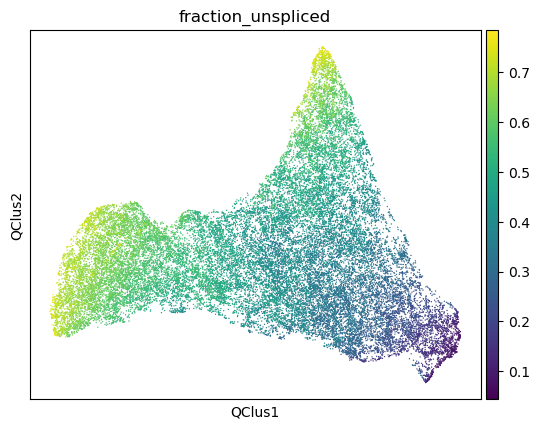

In [8]:
%matplotlib inline
sc.pl.embedding(adata, basis="QClus", color="fraction_unspliced")

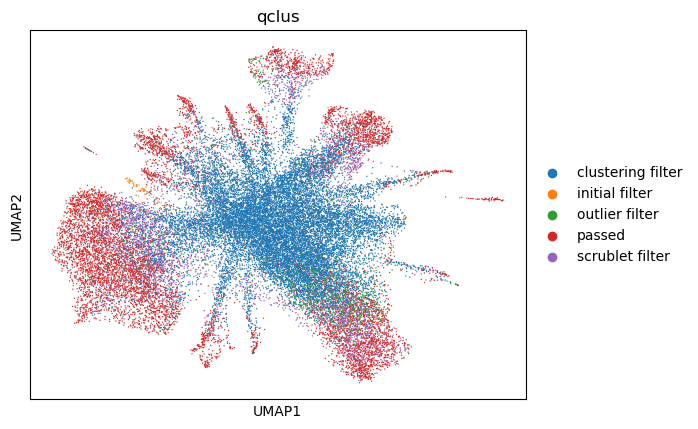

In [9]:
#run standard processing for visualization purposes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#save raw dataset and filter genes
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.filter_genes(adata, min_cells=10)
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_MT'], n_jobs = 30)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color="qclus")

In [10]:
adata = adata[adata.obs.qclus=="passed"]
adata

View of AnnData object with n_obs × n_vars = 8643 × 2745
    obs: 'fraction_unspliced', 'pct_counts_MT', 'total_counts', 'n_genes_by_counts', 'qclus', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'qclus_colors'
    obsm: 'QClus', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

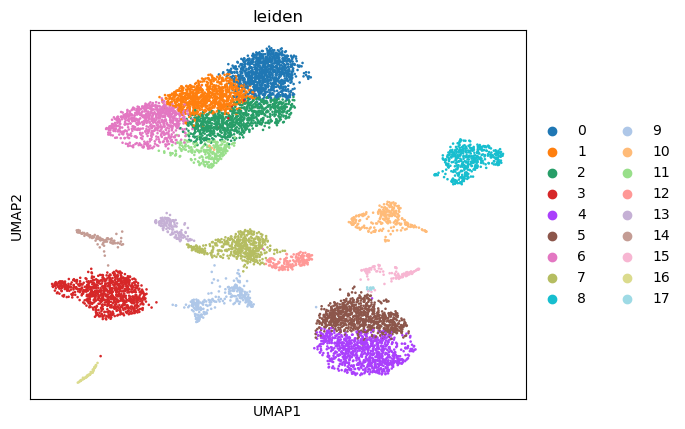

In [11]:
sc.tl.pca(adata, svd_solver='randomized')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

sc.pl.umap(adata, color="leiden")